In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import NMF

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
 
from tqdm.notebook import tqdm
 
import warnings
warnings.filterwarnings(action='ignore', category=sklearn.exceptions.DataConversionWarning)
warnings.filterwarnings(action='ignore', category=sklearn.exceptions.ConvergenceWarning)
 
random_seed = 42
sns.set_theme(style="whitegrid")

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
hashed_feature = pd.read_csv('hashed_feature.csv')
tabular_data = pd.read_csv('tabular_data.csv')

In [3]:
tabular_data.head()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,1,110.0,55.0,0.432017,0.000000,176.78,0.0,0.323712,NaN,147.0,0.0,176.78,55.0,0.248711,0.001373,0.0,0.0,0.0,0.476549,333.60,0.277617,55.0,0.0,55.0,21.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,1.00,55.000000,93.0,5562.0,93.0,0.040283,182.0,0.000000,43.50,0.0,0.0,0.00,0.00,0,0.000000,0.0,55.0,2.0,0.526552,145.0,133.28,0.0
1,0,2,110.0,110.0,0.397517,0.000000,315.42,0.0,0.316798,NaN,135.0,0.0,315.42,110.0,0.261744,-0.002248,0.0,0.0,0.0,0.210951,428.78,0.290904,110.0,0.0,110.0,26.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.77,110.000000,114.0,5532.0,114.0,0.047588,181.0,0.000000,85.45,0.0,0.0,15.75,0.00,0,0.000000,0.0,110.0,1.0,0.481063,130.0,229.97,0.0
2,0,3,110.0,55.0,0.359440,0.000000,354.55,0.0,0.339188,NaN,181.0,0.0,354.48,55.0,0.302164,0.002083,0.0,0.0,0.0,0.058675,526.38,0.284842,55.0,0.0,55.0,36.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.05,85249.281058,135.0,5501.0,136.0,0.051470,180.0,0.000000,122.70,0.0,0.0,0.00,0.07,0,0.000000,0.0,55.0,1.0,0.509598,180.0,231.78,0.0
3,0,4,110.0,55.0,0.285707,0.000000,229.98,0.0,0.415428,NaN,142.0,0.0,229.98,55.0,0.347660,0.005207,0.0,0.0,0.0,0.966854,398.98,0.285235,55.0,0.0,55.0,30.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.00,55.000000,102.0,5471.0,102.0,0.076190,179.0,0.000000,46.15,0.0,0.0,0.00,0.00,0,0.000000,0.0,55.0,0.0,0.680089,142.0,183.83,0.0
4,0,5,110.0,55.0,0.101487,444.730391,307.12,0.0,0.569670,NaN,92.0,0.0,306.17,55.0,0.438425,0.025736,0.0,21.0,0.0,0.700180,215.17,0.161147,55.0,0.0,55.0,20.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.0,0.00,55.000000,82.0,5440.0,95.0,0.273205,178.0,373.498562,150.33,0.0,0.0,26.75,0.95,0,20.014485,0.0,55.0,0.0,0.776175,85.0,155.83,0.0


In [4]:
#tabular_data['feature_51'] = tabular_data['feature_2'] - tabular_data['feature_46']
#tabular_data['feature_52'] = tabular_data['feature_6'] - tabular_data['feature_12']
#tabular_data['feature_53'] = tabular_data['feature_6'] - tabular_data['feature_2']

In [5]:
# train_set, valid_set = train_test_split(train.sample(500), test_size=0.25, random_state=random_seed)
train_set, valid_set = train_test_split(train, test_size=0.25, random_state=random_seed)
test_set = test.drop(columns=['score'])

In [6]:
train_all = pd.merge(train_set, tabular_data, how='left', on='id').sort_values(['id', 'period'])
valid_all = pd.merge(valid_set, tabular_data, how='left', on='id').sort_values(['id', 'period'])
test_all  = pd.merge(test, tabular_data, how='left', on='id').sort_values(['id', 'period'])

In [7]:
train_X = train_all.drop(columns=['target'])
train_y = train_all['target']

valid_X = valid_all.drop(columns=['target'])
valid_y = valid_all['target']

test_X = test_all

In [8]:
num_cols = list(train_X.select_dtypes([np.number]).columns)
cat_cols = list(train_X.select_dtypes([np.object]).columns)

In [9]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  
  def fit(self, X, y=None):
    return self
    
  def transform(self, X):
    selected = X[self.attribute_names].values
    # return selected.ravel() if selected.shape[1] == 1 else selected
    return selected

In [10]:
class MyLabelEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, f):
    self.fit_to = f
    self.encoder = LabelEncoder()
   
  def fit(self, x, y=None):
    self.encoder.fit(self.fit_to)
    return self

  def transform(self, x, y=None):
    return self.encoder.transform(x)[:, None]

In [11]:
class FeatureAdder(BaseEstimator, TransformerMixin):
  def __init__(self, columns, operation):
    self.columns = columns
    self.operation = operation
    
  def fit(self, x, y=None):
    return self

  def transform(self, x, y=None):
    matrix_columns = x.shape[1]
    df = pd.DataFrame(x, columns=self.columns + ['generated'] * (matrix_columns - len(self.columns)))

    users = list(df['id'].unique())

    prev_columns = self.columns[2:]
    new_columns = list(map(lambda x: x + '_', prev_columns))

    df[new_columns] = [[np.NaN] * len(new_columns)] * len(df)

    for user in tqdm(users):
      user_features = df[df['id'] == user]
      t = self.operation(user_features[prev_columns], user_features.shift(periods=-1)[prev_columns])
      t.columns = new_columns

      df.loc[df['id'] == user, new_columns] = t
      
    df.fillna(0, inplace=True)
    df.replace([np.inf, -np.inf], 999999, inplace=True)


    return df.values

In [12]:
def get_mean(x, y):
  t = pd.concat([pd.DataFrame([x.mean(axis=0).values])] * 12)
  t.columns = x.columns
  t.index = x.index
  return t

In [13]:
def get_median(x, y):
  t = pd.concat([pd.DataFrame([x.median(axis=0).values])] * 12)
  t.columns = x.columns
  t.index = x.index
  return t

In [14]:
def get_std(x, y):
  t = pd.concat([pd.DataFrame([x.std(axis=0).values])] * 12)
  t.columns = x.columns
  t.index = x.index
  return t

In [15]:
num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_cols)),
                         ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                         ('feature_adder_sub', FeatureAdder(num_cols, lambda a, b: a - b)),
                         ('feature_adder_sum', FeatureAdder(num_cols, lambda a, b: a + b)),
                         ('feature_adder_div', FeatureAdder(num_cols, lambda a, b: a * b)),
                         ('feature_adder_mul', FeatureAdder(num_cols, lambda a, b: a / b)),
                         ('feature_adder_sum_agg', FeatureAdder(num_cols, lambda a, b: get_mean(a, b))),
                         ('feature_adder_med_agg', FeatureAdder(num_cols, lambda a, b: get_median(a, b))),
                         ('feature_adder_std_agg', FeatureAdder(num_cols, lambda a, b: get_median(a, b))),
                         ])

cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(cat_cols)),
                         ('label_encoder', MyLabelEncoder(tabular_data['feature_25']))
])

full_pipeline = FeatureUnion(transformer_list=[
                                               ("num_pipeline", num_pipeline),
                                               ("cat_pipeline", cat_pipeline),
])

In [16]:
transformed_X_train = pd.DataFrame(full_pipeline.fit_transform(train_X))
transformed_X_valid = pd.DataFrame(full_pipeline.transform(valid_X))
transformed_X_test = pd.DataFrame(full_pipeline.transform(test_X))

gen_cols = ['generated_' + str(i) for i in range(transformed_X_train.shape[1] - len(num_cols) - len(cat_cols))]

transformed_X_train.columns = num_cols + gen_cols + cat_cols
transformed_X_valid.columns = num_cols + gen_cols + cat_cols
transformed_X_test.columns = num_cols + gen_cols + cat_cols
transformed_X_train

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,generated_304,generated_305,generated_306,generated_307,generated_308,generated_309,generated_310,generated_311,generated_312,generated_313,generated_314,generated_315,generated_316,generated_317,generated_318,generated_319,generated_320,generated_321,generated_322,generated_323,generated_324,generated_325,generated_326,generated_327,generated_328,generated_329,generated_330,generated_331,generated_332,generated_333,generated_334,generated_335,generated_336,generated_337,generated_338,generated_339,generated_340,generated_341,generated_342,feature_25
0,1.0,1.0,110.0,125.00,0.083174,5893.939371,812.20,0.000000,0.417209,392.57,81.0,0.870000,802.62,41802.758835,0.313205,0.090314,0.0,30.000000,0.000000,0.330429,398.38,0.199661,125.00,0.00,125.00,32.0,0.0,100.991019,0.000000,5.82,125.00,107.000000,5033.0,113.0,0.313646,165.0,5797.233157,282.47,0.0,0.0,...,1077.955,125.0,0.268976,0.113113,0.0,30.000000,0.0,0.466857,1096.500,0.133309,125.0,0.00,125.0,26.0,0.0,100.991019,0.000000,4.995,125.00,109.500000,4865.0,110.0,0.391139,159.5,6166.220797,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0
1,1.0,2.0,110.0,125.00,0.096831,5805.264756,945.20,0.000000,0.432038,782.33,121.0,8.750000,936.40,125.000000,0.350123,0.061025,0.0,31.000000,17087.543582,0.295584,789.72,0.199080,125.00,0.00,125.00,23.0,0.0,100.991019,0.000000,7.38,125.17,118.000000,5003.0,123.0,0.292942,164.0,5207.866393,266.57,0.0,0.0,...,1077.955,125.0,0.268976,0.113113,0.0,30.000000,0.0,0.466857,1096.500,0.133309,125.0,0.00,125.0,26.0,0.0,100.991019,0.000000,4.995,125.00,109.500000,4865.0,110.0,0.391139,159.5,6166.220797,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0
2,1.0,3.0,110.0,125.00,0.218627,6696.448984,837.60,0.000000,0.341146,1057.55,105.0,0.000000,837.60,125.000000,0.286786,0.021085,0.0,30.000000,0.000000,0.542783,1068.40,0.310264,125.00,0.00,125.00,25.0,0.0,100.991019,0.000000,10.85,125.00,99.000000,4972.0,99.0,0.163238,163.0,6290.855101,329.75,0.0,0.0,...,1077.955,125.0,0.268976,0.113113,0.0,30.000000,0.0,0.466857,1096.500,0.133309,125.0,0.00,125.0,26.0,0.0,100.991019,0.000000,4.995,125.00,109.500000,4865.0,110.0,0.391139,159.5,6166.220797,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0
3,1.0,4.0,110.0,125.00,0.049890,9583.248231,631.70,0.000000,0.369767,465.43,79.0,4767.378484,631.15,125.000000,0.289090,0.079627,0.0,31.000000,0.000000,0.388980,465.78,0.196277,125.00,0.00,125.00,23.0,0.0,100.991019,0.000000,0.35,125.00,90.000000,4942.0,93.0,0.385117,162.0,9077.415250,81.18,0.0,0.0,...,1077.955,125.0,0.268976,0.113113,0.0,30.000000,0.0,0.466857,1096.500,0.133309,125.0,0.00,125.0,26.0,0.0,100.991019,0.000000,4.995,125.00,109.500000,4865.0,110.0,0.391139,159.5,6166.220797,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0
4,1.0,5.0,110.0,125.00,0.057157,6723.063635,1247.88,0.000000,0.672621,1121.62,108.0,3.170000,1244.17,125.000000,0.344224,0.090021,0.0,31.000000,0.000000,0.053928,1124.60,0.155106,125.00,0.00,125.00,25.0,0.0,100.991019,0.000000,-2.98,123.00,125.000000,4911.0,-128.0,0.353492,161.0,6432.578444,257.58,0.0,0.0,...,1077.955,125.0,0.268976,0.113113,0.0,30.000000,0.0,0.466857,1096.500,0.133309,125.0,0.00,125.0,26.0,0.0,100.991019,0.000000,4.995,125.00,109.500000,4865.0,110.0,0.391139,159.5,6166.220797,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [17]:
model = RandomForestClassifier(max_depth=7, class_weight='balanced', n_jobs=-1, random_state=random_seed)
model.fit(transformed_X_train[num_cols + cat_cols], train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [18]:
preds_train = pd.Series(model.predict(transformed_X_train[num_cols + cat_cols]))
preds_valid = pd.Series(model.predict(transformed_X_valid[num_cols + cat_cols]))
preds_test = pd.Series(model.predict(transformed_X_test[num_cols + cat_cols]))

print('train auc score:', roc_auc_score(train_y, preds_train), f1_score(train_y, preds_train))
print('valid auc score:', roc_auc_score(valid_y, preds_valid), f1_score(valid_y, preds_valid))
print('mean:', preds_valid.mean())

train auc score: 0.7259979885183641 0.5860546448087431
valid auc score: 0.670930443378138 0.5153906866614049
mean: 0.35896180215475026


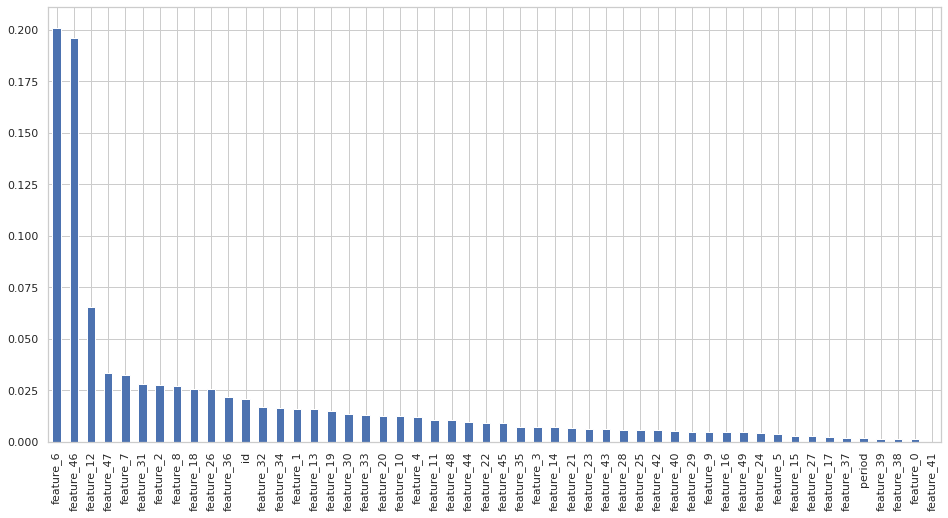

In [19]:
features_importance = pd.Series(model.feature_importances_, index=num_cols+cat_cols).sort_values(ascending=False)

plt.figure(figsize=(16, 8))
features_importance.plot.bar();

In [20]:
preprocessed_hashed = hashed_feature.copy()
preprocessed_hashed['feature_50'] = LabelEncoder().fit_transform(preprocessed_hashed['feature_50'].astype(str))
preprocessed_hashed.head()

,id,feature_50
0,0,2367
1,0,1404
2,0,3314
3,0,1543
4,0,4179


In [21]:
unique_users = preprocessed_hashed['id'].unique()
unique_vals = preprocessed_hashed['feature_50'].unique()

one_hot_users = np.zeros((len(unique_users), len(unique_vals)))

for user in tqdm(unique_users):
  for value in preprocessed_hashed[preprocessed_hashed['id'] == user]['feature_50']:
    one_hot_users[user][value] += 1

one_hot_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
decomposition_model = NMF(n_components=20, init='random', random_state=random_seed)
W = decomposition_model.fit_transform(one_hot_users)
W.shape

(5106, 20)

In [23]:
counts = preprocessed_hashed.groupby(by='id').count()['feature_50'].values

bandwidth = estimate_bandwidth(W, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(W)
km = KMeans(n_clusters=20, random_state=0).fit(W)
db = DBSCAN(eps=0.3, min_samples=10).fit(W)
gaus_labels = GaussianMixture(n_components=10).fit_predict(W)

In [24]:
df = pd.DataFrame(np.c_[W, km.labels_, db.labels_, gaus_labels, ms.labels_, counts], index=range(W.shape[0])).reset_index()
df.columns = ['id'] + ['c' + str(i) for i in range(df.shape[1] - 6)] + ['Kmeans', 'DBSCAN', 'GAUS', 'MeanShift', 'counts']
df

,id,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,Kmeans,DBSCAN,GAUS,MeanShift,counts
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.078572,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.013047,0.042819,5.0,0.0,0.0,0.0,10.0
1,1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.213209,0.000000,0.073311,0.000000,0.000000,0.033897,0.000000,0.003601,0.0,0.000000,0.006339,0.000000,0.000000,0.000000,5.0,0.0,4.0,0.0,43.0
2,2,0.000000,0.004181,0.000655,0.0,0.000000,0.011590,0.000000,0.000000,0.081872,0.000000,0.000000,0.000493,0.000000,0.000000,0.0,0.001096,0.025804,0.000000,0.001493,0.002286,5.0,0.0,3.0,0.0,15.0
3,3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048712,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,0.0,4.0,0.0,6.0
4,4,0.934780,0.000000,0.109252,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.121044,0.000000,0.142169,0.000000,0.000000,3.0,0.0,8.0,1.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,5101,0.000000,1.496944,0.000000,0.0,0.255867,0.000000,0.002022,0.000000,0.000000,0.000000,0.000000,0.042455,0.038286,0.156438,0.0,0.018302,0.000000,0.000566,0.000000,0.000000,6.0,-1.0,2.0,2.0,107.0
5102,5102,0.000000,0.250363,0.000000,0.0,0.005677,0.114966,0.040537,0.031136,0.021481,0.010994,0.073013,0.035305,0.000000,0.048102,0.0,0.000000,0.022769,0.000000,0.016843,0.000000,5.0,0.0,7.0,0.0,83.0
5103,5103,0.000000,0.000000,0.000876,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005429,0.000000,0.000000,0.006010,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,0.0,4.0,0.0,6.0
5104,5104,0.037712,0.000000,0.000000,0.0,0.028641,0.000000,0.000000,0.000000,0.000126,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,0.0,5.0,0.0,10.0


In [25]:
clastered_X_train = pd.merge(train_set.drop(columns=['target']), df, how='left', on='id')
clastered_X_valid = pd.merge(valid_set.drop(columns=['target']), df, how='left', on='id')
clastered_X_test = pd.merge(test_set, df, how='left', on='id')
clastered_X_train.shape

(3063, 26)

In [26]:
model2 = RandomForestClassifier(max_depth=5, class_weight='balanced', n_jobs=-1, random_state=random_seed)
model2.fit(clastered_X_train.drop(columns=['id']), train_set['target'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [27]:
preds_train2 = pd.Series(model2.predict(clastered_X_train.drop(columns=['id'])))
preds_valid2 = pd.Series(model2.predict(clastered_X_valid.drop(columns=['id'])))

print('train auc score:', roc_auc_score(train_set['target'], preds_train2), f1_score(train_set['target'], preds_train2))
print('valid auc score:', roc_auc_score(valid_set['target'], preds_valid2), f1_score(valid_set['target'], preds_valid2))
print('mean:', preds_valid2.mean())

train auc score: 0.680923031327523 0.5296100144439095
valid auc score: 0.6247553621633435 0.46458923512747874
mean: 0.4299706170421156


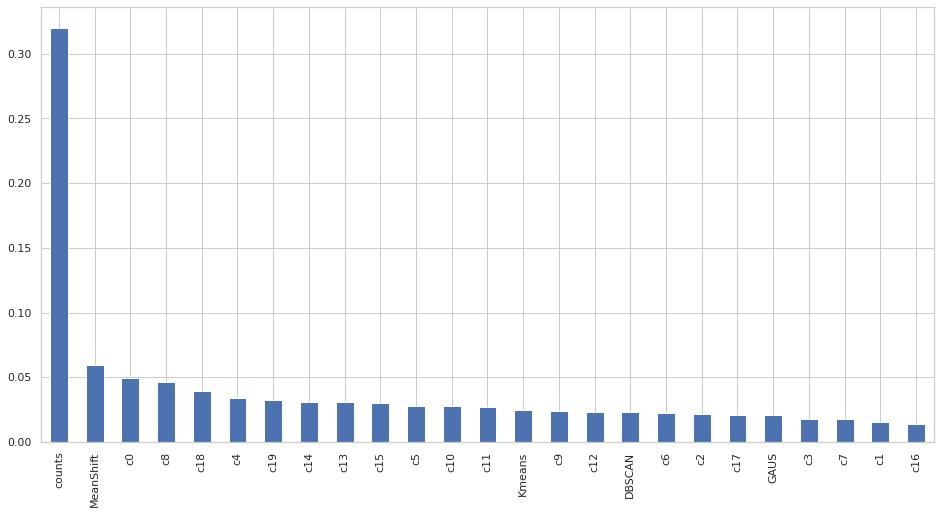

In [28]:
features_importance2 = pd.Series(model2.feature_importances_, index=clastered_X_train.drop(columns=['id']).columns).sort_values(ascending=False)

plt.figure(figsize=(16, 8))
features_importance2.plot.bar();

In [29]:
train_X_with_preds = pd.merge(transformed_X_train, preds_train.to_frame(name="predictions"), how='left', left_index=True, right_index=True)
valid_X_with_preds = pd.merge(transformed_X_valid, preds_valid.to_frame(name="predictions"), how='left', left_index=True, right_index=True)
test_X_with_preds = pd.merge(transformed_X_test, preds_test.to_frame(name="predictions"), how='left', left_index=True, right_index=True)
train_X_with_preds.head()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,generated_305,generated_306,generated_307,generated_308,generated_309,generated_310,generated_311,generated_312,generated_313,generated_314,generated_315,generated_316,generated_317,generated_318,generated_319,generated_320,generated_321,generated_322,generated_323,generated_324,generated_325,generated_326,generated_327,generated_328,generated_329,generated_330,generated_331,generated_332,generated_333,generated_334,generated_335,generated_336,generated_337,generated_338,generated_339,generated_340,generated_341,generated_342,feature_25,predictions
0,1.0,1.0,110.0,125.0,0.083174,5893.939371,812.20,0.0,0.417209,392.57,81.0,0.870000,802.62,41802.758835,0.313205,0.090314,0.0,30.0,0.000000,0.330429,398.38,0.199661,125.0,0.0,125.0,32.0,0.0,100.991019,0.0,5.82,125.00,107.0,5033.0,113.0,0.313646,165.0,5797.233157,282.47,0.0,0.0,...,125.0,0.268976,0.113113,0.0,30.0,0.0,0.466857,1096.5,0.133309,125.0,0.0,125.0,26.0,0.0,100.991019,0.0,4.995,125.0,109.5,4865.0,110.0,0.391139,159.5,6166.220797,302.6,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0
1,1.0,2.0,110.0,125.0,0.096831,5805.264756,945.20,0.0,0.432038,782.33,121.0,8.750000,936.40,125.000000,0.350123,0.061025,0.0,31.0,17087.543582,0.295584,789.72,0.199080,125.0,0.0,125.0,23.0,0.0,100.991019,0.0,7.38,125.17,118.0,5003.0,123.0,0.292942,164.0,5207.866393,266.57,0.0,0.0,...,125.0,0.268976,0.113113,0.0,30.0,0.0,0.466857,1096.5,0.133309,125.0,0.0,125.0,26.0,0.0,100.991019,0.0,4.995,125.0,109.5,4865.0,110.0,0.391139,159.5,6166.220797,302.6,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0
2,1.0,3.0,110.0,125.0,0.218627,6696.448984,837.60,0.0,0.341146,1057.55,105.0,0.000000,837.60,125.000000,0.286786,0.021085,0.0,30.0,0.000000,0.542783,1068.40,0.310264,125.0,0.0,125.0,25.0,0.0,100.991019,0.0,10.85,125.00,99.0,4972.0,99.0,0.163238,163.0,6290.855101,329.75,0.0,0.0,...,125.0,0.268976,0.113113,0.0,30.0,0.0,0.466857,1096.5,0.133309,125.0,0.0,125.0,26.0,0.0,100.991019,0.0,4.995,125.0,109.5,4865.0,110.0,0.391139,159.5,6166.220797,302.6,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0
3,1.0,4.0,110.0,125.0,0.049890,9583.248231,631.70,0.0,0.369767,465.43,79.0,4767.378484,631.15,125.000000,0.289090,0.079627,0.0,31.0,0.000000,0.388980,465.78,0.196277,125.0,0.0,125.0,23.0,0.0,100.991019,0.0,0.35,125.00,90.0,4942.0,93.0,0.385117,162.0,9077.415250,81.18,0.0,0.0,...,125.0,0.268976,0.113113,0.0,30.0,0.0,0.466857,1096.5,0.133309,125.0,0.0,125.0,26.0,0.0,100.991019,0.0,4.995,125.0,109.5,4865.0,110.0,0.391139,159.5,6166.220797,302.6,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0
4,1.0,5.0,110.0,125.0,0.057157,6723.063635,1247.88,0.0,0.672621,1121.62,108.0,3.170000,1244.17,125.000000,0.344224,0.090021,0.0,31.0,0.000000,0.053928,1124.60,0.155106,125.0,0.0,125.0,25.0,0.0,100.991019,0.0,-2.98,123.00,125.0,4911.0,-128.0,0.353492,161.0,6432.578444,257.58,0.0,0.0,...,125.0,0.268976,0.113113,0.0,30.0,0.0,0.466857,1096.5,0.133309,125.0,0.0,125.0,26.0,0.0,100.991019,0.0,4.995,125.0,109.5,4865.0,110.0,0.391139,159.5,6166.220797,302.6,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0


In [30]:
predicitons_train = train_X_with_preds.groupby('id').mean()['predictions']
predicitons_valid = valid_X_with_preds.groupby('id').mean()['predictions']
predicitons_test = test_X_with_preds.groupby('id').mean()['predictions']

predicitons_train


id
1.0       0.000000
2.0       0.416667
3.0       0.000000
4.0       0.916667
5.0       0.000000
            ...   
4076.0    0.000000
4077.0    0.416667
4080.0    0.000000
4082.0    0.000000
4083.0    1.000000
Name: predictions, Length: 3063, dtype: float64

In [31]:
actual_train_y = train_set.sort_values(by='id')
actual_valid_y = valid_set.sort_values(by='id')
actual_test_y = test_set.sort_values(by='id')
actual_valid_y['target']

0       0
6       1
8       1
12      1
14      1
       ..
4069    0
4071    0
4078    0
4079    0
4081    0
Name: target, Length: 1021, dtype: int64

In [32]:
print(roc_auc_score(actual_train_y['target'], predicitons_train))
print(roc_auc_score(actual_valid_y['target'], predicitons_valid))

0.8016843757546486
0.7302079297429936


In [33]:
full_train_data = pd.merge(transformed_X_train, clastered_X_train, how='left', on='id')
full_valid_data = pd.merge(transformed_X_valid, clastered_X_valid, how='left', on='id')
full_test_data = pd.merge(transformed_X_test, clastered_X_test, how='left', on='id')
full_train_data

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,generated_329,generated_330,generated_331,generated_332,generated_333,generated_334,generated_335,generated_336,generated_337,generated_338,generated_339,generated_340,generated_341,generated_342,feature_25,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,Kmeans,DBSCAN,GAUS,MeanShift,counts
0,1.0,1.0,110.0,125.00,0.083174,5893.939371,812.20,0.000000,0.417209,392.57,81.0,0.870000,802.62,41802.758835,0.313205,0.090314,0.0,30.000000,0.000000,0.330429,398.38,0.199661,125.00,0.00,125.00,32.0,0.0,100.991019,0.000000,5.82,125.00,107.000000,5033.0,113.0,0.313646,165.0,5797.233157,282.47,0.0,0.0,...,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.213209,0.000000,0.073311,0.0,0.000000,0.033897,0.0,0.003601,0.0,0.0,0.006339,0.0,0.0,0.0,5.0,0.0,4.0,0.0,43.0
1,1.0,2.0,110.0,125.00,0.096831,5805.264756,945.20,0.000000,0.432038,782.33,121.0,8.750000,936.40,125.000000,0.350123,0.061025,0.0,31.000000,17087.543582,0.295584,789.72,0.199080,125.00,0.00,125.00,23.0,0.0,100.991019,0.000000,7.38,125.17,118.000000,5003.0,123.0,0.292942,164.0,5207.866393,266.57,0.0,0.0,...,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.213209,0.000000,0.073311,0.0,0.000000,0.033897,0.0,0.003601,0.0,0.0,0.006339,0.0,0.0,0.0,5.0,0.0,4.0,0.0,43.0
2,1.0,3.0,110.0,125.00,0.218627,6696.448984,837.60,0.000000,0.341146,1057.55,105.0,0.000000,837.60,125.000000,0.286786,0.021085,0.0,30.000000,0.000000,0.542783,1068.40,0.310264,125.00,0.00,125.00,25.0,0.0,100.991019,0.000000,10.85,125.00,99.000000,4972.0,99.0,0.163238,163.0,6290.855101,329.75,0.0,0.0,...,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.213209,0.000000,0.073311,0.0,0.000000,0.033897,0.0,0.003601,0.0,0.0,0.006339,0.0,0.0,0.0,5.0,0.0,4.0,0.0,43.0
3,1.0,4.0,110.0,125.00,0.049890,9583.248231,631.70,0.000000,0.369767,465.43,79.0,4767.378484,631.15,125.000000,0.289090,0.079627,0.0,31.000000,0.000000,0.388980,465.78,0.196277,125.00,0.00,125.00,23.0,0.0,100.991019,0.000000,0.35,125.00,90.000000,4942.0,93.0,0.385117,162.0,9077.415250,81.18,0.0,0.0,...,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.213209,0.000000,0.073311,0.0,0.000000,0.033897,0.0,0.003601,0.0,0.0,0.006339,0.0,0.0,0.0,5.0,0.0,4.0,0.0,43.0
4,1.0,5.0,110.0,125.00,0.057157,6723.063635,1247.88,0.000000,0.672621,1121.62,108.0,3.170000,1244.17,125.000000,0.344224,0.090021,0.0,31.000000,0.000000,0.053928,1124.60,0.155106,125.00,0.00,125.00,25.0,0.0,100.991019,0.000000,-2.98,123.00,125.000000,4911.0,-128.0,0.353492,161.0,6432.578444,257.58,0.0,0.0,...,302.600,0.0,0.0,0.0,0.535,0.0,3529.394494,0.0,125.0,6.0,0.363216,123.5,288.901017,1.5,7.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.213209,0.000000,0.073311,0.0,0.000000,0.033897,0.0,0.003601,0.0,0.0,0.006339,0.0,0.0,0.0,5.0,0.0,4.0,0.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36751,4083.0,8.0,110.0,326.97,0.075341,51748.802468,183.98,51853.985279,0.816545,143.07,114.0,7.050000,175.30,326.970000,0.451864,0.050586,0.0,10.720671,1.000000,0.169997,147.28,0.152262,316.17,10.80,

In [34]:
full_test_data.shape

(12264, 420)

In [35]:
model3 = RandomForestClassifier(max_depth=7, class_weight='balanced', n_jobs=-1, random_state=random_seed)
model3.fit(full_train_data, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [36]:
preds_train3 = pd.Series(model3.predict(full_train_data))
preds_valid3 = pd.Series(model3.predict(full_valid_data))

print('train auc score:', roc_auc_score(train_y, preds_train3), f1_score(train_y, preds_train3))
print('valid auc score:', roc_auc_score(valid_y, preds_valid3), f1_score(valid_y, preds_valid3))
print('mean:', preds_valid.mean())

train auc score: 0.841778514741718 0.7446360959192259
valid auc score: 0.6969618133169082 0.5492820298341001
mean: 0.35896180215475026


In [37]:
features_importance3 = pd.Series(model3.feature_importances_, index=full_train_data.columns).sort_values(ascending=False)

In [38]:
best_features = list(features_importance3.sort_values(ascending=False)[:70].index)
best_features[:10]

['generated_290',
 'generated_241',
 'generated_300',
 'generated_339',
 'generated_251',
 'generated_202',
 'counts',
 'feature_6',
 'feature_46',
 'generated_94']

In [39]:
X_train_with_best_features = full_train_data[best_features]
X_valid_with_best_features = full_valid_data[best_features]
X_test_with_best_features = full_test_data[best_features]

X_train_with_base_features = full_train_data[num_cols + cat_cols]
X_valid_with_base_features = full_valid_data[num_cols + cat_cols]
X_test_with_base_features = full_test_data[num_cols + cat_cols]

X_train_with_clastered_features = clastered_X_train
X_valid_with_clastered_features = clastered_X_valid
X_test_with_clastered_features = clastered_X_test

train_sets = [X_train_with_best_features, X_train_with_base_features, X_train_with_clastered_features]
valid_sets = [X_valid_with_best_features, X_valid_with_base_features, X_valid_with_clastered_features]
test_sets = [X_test_with_best_features, X_test_with_base_features, X_test_with_clastered_features]

In [40]:
print(X_train_with_best_features.columns[:4])
print(X_train_with_base_features.columns[:4])
print(X_valid_with_clastered_features.columns[:4])

Index(['generated_290', 'generated_241', 'generated_300', 'generated_339'], dtype='object')
Index(['id', 'period', 'feature_0', 'feature_1'], dtype='object')
Index(['id', 'c0', 'c1', 'c2'], dtype='object')


In [41]:
model = RandomForestClassifier(max_depth=7, class_weight='balanced', n_jobs=-1, random_state=random_seed)

model.fit(X_train_with_best_features, train_y)
p1t = pd.Series(model.predict(X_train_with_best_features))
p1v = pd.Series(model.predict(X_valid_with_best_features))
p1s = pd.Series(model.predict(X_test_with_best_features))

model.fit(X_train_with_base_features, train_y)
p2t = pd.Series(model.predict(X_train_with_base_features))
p2v = pd.Series(model.predict(X_valid_with_base_features))
p2s = pd.Series(model.predict(X_test_with_base_features))

model.fit(X_train_with_clastered_features, train_set['target'])
p3t = pd.Series(model.predict(X_train_with_clastered_features.sort_values(by='id')))
p3v = pd.Series(model.predict(X_valid_with_clastered_features.sort_values(by='id')))
p3s = pd.Series(model.predict(X_test_with_clastered_features.sort_values(by='id')))

In [42]:
train_pred12 = pd.concat([p1t, p2t], axis=1)
valid_pred12 = pd.concat([p1v, p2v], axis=1)
test_pred12 = pd.concat([p1s, p2s], axis=1)

In [43]:
full_train_with_preds = pd.merge(full_train_data, train_pred12, how='left', left_index=True, right_index=True)
full_valid_with_preds = pd.merge(full_valid_data, valid_pred12, how='left', left_index=True, right_index=True)
full_test_with_preds = pd.merge(full_test_data, test_pred12, how='left', left_index=True, right_index=True)

In [44]:
preds_train = full_train_with_preds.groupby('id').mean()[[0, 1]]
preds_valid = full_valid_with_preds.groupby('id').mean()[[0, 1]]
preds_test = full_test_with_preds.groupby('id').mean()[[0, 1]]

preds_train[2] = p3t.values
preds_valid[2] = p3v.values
preds_test[2] = p3s.values

preds_test.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1022 entries, 4084.0 to 5105.0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1022 non-null   float64
 1   1       1022 non-null   float64
 2   2       1022 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 31.9 KB


In [45]:
print(roc_auc_score(actual_valid_y['target'], preds_valid[0]))
print(roc_auc_score(actual_valid_y['target'], preds_valid[1]))
print(roc_auc_score(actual_valid_y['target'], preds_valid[2]))

0.7137911165419883
0.7302079297429936
0.6244374571573331


In [46]:
final_model = RandomForestClassifier(n_estimators=300, max_depth=3, class_weight='balanced_subsample', n_jobs=-1, random_state=random_seed)
final_model.fit(preds_train, actual_train_y['target'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [47]:
final_pred_train = final_model.predict_proba(preds_train)[:, 1]
final_pred_valid = final_model.predict_proba(preds_valid)[:, 1]
final_pred_test = final_model.predict_proba(preds_test)[:, 1]

In [48]:
print('train auc score:', roc_auc_score(actual_train_y['target'], final_pred_train))
print('valid auc score:', roc_auc_score(actual_valid_y['target'], final_pred_valid))
print('mean:', final_pred_train.mean())

train auc score: 0.8965395929836886
valid auc score: 0.7485172711829047
mean: 0.3829570578004968


In [49]:
my_prediciton = pd.Series(final_pred_test)
test['score'] = my_prediciton.values
test = test.set_index('id')
test.to_csv('submission.csv')